## <span style="color: blue;">1️⃣ <b><u>Import Libraries</u></b> </span>

In [39]:
# Import necessary libraries for data retrieval, processing, and visualization
import yfinance as yf  # Yahoo Finance API to download historical market data
import matplotlib.pyplot as plt  # Library for creating static, animated, and interactive visualizations
from datetime import datetime as dt  # Library for manipulating dates and times
import numpy as np  # Library for numerical computing
import pandas as pd  # Library for data manipulation and analysis
from backtesting import Backtest, Strategy  # Libraries for backtesting trading strategies
from backtesting.lib import crossover  # Helper function to identify crossovers between two series
from backtesting.test import GOOG  # Sample dataset provided by the backtesting library
from pandas_datareader import data as web  # Library for remote data access to financial data
import talib  # Technical Analysis Library for financial market data

# Suppress warnings to keep the output clean
import warnings
warnings.filterwarnings('ignore')

## <span style="color: green;">2️⃣ <b><u>Pull Data From Yahoo Finance</u></b></span>

In [259]:
def get_stock_data(ticker, start_date, end_date, interval):
    """
    Retrieves historical stock data for a given ticker symbol within a specified date range and interval.
    
    Parameters:
    ticker (str): The stock ticker symbol (e.g., 'AAPL' for Apple).
    start_date (str): The start date for the data retrieval (format: 'YYYY-MM-DD').
    end_date (str): The end date for the data retrieval (format: 'YYYY-MM-DD').
    interval (str): The data interval (e.g., '1d' for daily data, '1wk' for weekly data).
    
    Returns:
    DataFrame: A pandas DataFrame containing the historical stock data with columns: 'Open', 'High', 'Low', 'Close', 'Volume'.
    """
    
    # Download historical data for the given ticker
    df = yf.download(ticker, start=start_date, end=end_date, interval=interval)
    df.dropna(inplace=True)  # Remove any rows with missing values
    
    # Drop the 'Adj Close' column if it exists
    if 'Adj Close' in df.columns:
        df.drop(columns=['Adj Close'], inplace=True)
    
    # Ensure single-level column names
    df.columns = df.columns.get_level_values(0)  # Flatten multi-level columns, if any
    df.columns.name = None  # Remove the name attribute from columns
    
    # Reset index to include Date column
    df.reset_index(inplace=True)
    df.set_index('Date', inplace=True)  # Set 'Date' column as the index
    
    # Ensure columns are in the correct order
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    
    return df

## 3️⃣ <span style="color: red;"><b><u>Backtesting Trading Strategies</u></b></span>

### Configuring Global Variables

In [179]:
# List of stocks (holdings of FBGRX)
holdings = ['MSFT', 'AAPL', 'AMZN', 'GOOGL', 'META']

# Define the time period
start_date = '2010-01-01'
end_date = '2023-12-31'

# Fund to be invested for backtesting
cash_in_hand = 1000

# Brokerage to be assumed for backtesting
brokerage = .002

### Creating DF to collect all stats

In [255]:
# Initialize an empty list to store the stats
all_stats = []

### <b> 1. </b> Moving Average Ribbon Strategy

In [253]:
class MovingAverageRibbonStrategy(Strategy):
    short_window = 10  # Shortest moving average
    long_window = 50  # Longest moving average

    def init(self):
        # Convert Close prices to Pandas Series and calculate moving averages
        close_series = pd.Series(self.data.Close, index=self.data.index)
        self.short_ma = self.I(lambda: close_series.rolling(self.short_window).mean())
        self.long_ma = self.I(lambda: close_series.rolling(self.long_window).mean())

    def next(self):
        if len(self.data) < self.long_window:
            return

        # Buy Signal: Short MA crosses above Long MA
        if not self.position and crossover(self.short_ma, self.long_ma):
            self.buy()

        # Sell Signal: Short MA crosses below Long MA
        elif self.position and crossover(self.long_ma, self.short_ma):
            self.sell()


# Applying the Moving Average Ribbon Strategy

# Create a DataFrame to store yearly returns for each stock
yearly_returns_df_mar = pd.DataFrame()

# Backtest the strategy for each stock in holdings
for ticker in holdings:
    # Download historical data for backtesting
    df = get_stock_data(ticker, start_date, end_date, '1d')
    
    # Backtest the strategy
    bt = Backtest(df, MovingAverageRibbonStrategy, cash=cash_in_hand, commission=brokerage)
    stats = bt.run()

    # Add ticker symbol to the stats 
    stock_stats = stats.to_dict() 
    stock_stats['Ticker'] = ticker 
    del stock_stats['_equity_curve'] 
    del stock_stats['_trades']
    all_stats.append(stock_stats)
    
    # Extract the equity curve and calculate yearly returns
    equity_curve = stats['_equity_curve']['Equity']
    yearly_returns = equity_curve.resample('Y').last().pct_change().fillna(0) * 100
    
    # Ensure the DataFrame has all years from start_date to end_date
    all_years = pd.date_range(start=start_date, end=end_date, freq='Y')
    yearly_returns = yearly_returns.reindex(all_years, fill_value=0)
    
    yearly_returns_df_mar[ticker] = yearly_returns.values

# Calculate the average yearly returns across all stocks for the strategy
average_yearly_returns_mar = yearly_returns_df_mar.mean(axis=1)

# Create a DataFrame with "Date" and "Average Yearly Returns (%)"
average_yearly_returns_df_1 = pd.DataFrame({
    'Date': yearly_returns_df_mar.index,
    'Average Yearly Returns (%)': average_yearly_returns_mar
})

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### <b> 2. </b> SuperTrend Strategy

In [225]:
def ATR(df, n=14):
    """
    Calculate the Average True Range (ATR)
    """
    df['H-L'] = abs(df['High'] - df['Low'])
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
    df['ATR'] = df['TR'].rolling(n).mean()
    df.drop(['H-L', 'H-PC', 'L-PC', 'TR'], axis=1, inplace=True)
    return df

def SuperTrend(df, period=7, multiplier=3):
    """
    Calculate the SuperTrend indicator
    """
    df = ATR(df, period)
    df['Upper Band'] = ((df['High'] + df['Low']) / 2) + (multiplier * df['ATR'])
    df['Lower Band'] = ((df['High'] + df['Low']) / 2) - (multiplier * df['ATR'])
    df['SuperTrend'] = 0.0

    for current in range(1, len(df.index)):
        if (df['Close'][current] > df['Upper Band'][current - 1]):
            df['SuperTrend'][current] = df['Lower Band'][current]
        elif (df['Close'][current] < df['Lower Band'][current - 1]):
            df['SuperTrend'][current] = df['Upper Band'][current]
        else:
            df['SuperTrend'][current] = df['SuperTrend'][current - 1]

    return df

class SuperTrendStrategy(Strategy):
    def init(self):
        supertrend_df = SuperTrend(pd.DataFrame(self.data.df))  # Calculate SuperTrend
        self.supertrend = self.I(lambda: supertrend_df['SuperTrend'])

    def next(self):
        if not self.position and self.data.Close[-1] > self.supertrend[-1]:
            self.buy()
        elif self.position and self.data.Close[-1] < self.supertrend[-1]:
            self.sell()

# Applying the SuperTrend Strategy

# Create a DataFrame to store yearly returns for each stock
yearly_returns_df_st = pd.DataFrame()

# Backtest the strategy for each stock in holdings
for ticker in holdings:
    # Download historical data for backtesting
    df = get_stock_data(ticker, start_date, end_date, '1d')
    
    # Backtest the strategy
    bt = Backtest(df, SuperTrendStrategy, cash=cash_in_hand, commission=brokerage)
    stats = bt.run()

    # Add ticker symbol to the stats 
    stock_stats = stats.to_dict() 
    stock_stats['Ticker'] = ticker 
    del stock_stats['_equity_curve'] 
    del stock_stats['_trades']
    all_stats.append(stock_stats)
    
    # Extract the equity curve and calculate yearly returns
    equity_curve = stats['_equity_curve']['Equity']
    yearly_returns = equity_curve.resample('Y').last().pct_change().fillna(0) * 100
    
    # Ensure the DataFrame has all years from start_date to end_date
    all_years = pd.date_range(start=start_date, end=end_date, freq='Y')
    yearly_returns = yearly_returns.reindex(all_years, fill_value=0)
    
    yearly_returns_df_st[ticker] = yearly_returns.values

# Calculate the average yearly returns across all stocks for the strategy
average_yearly_returns_st = yearly_returns_df_st.mean(axis=1)

# Create a DataFrame with "Date" and "Average Yearly Returns (%)"
average_yearly_returns_df_2 = pd.DataFrame({
    'Date': yearly_returns_df_st.index,
    'Average Yearly Returns (%)': average_yearly_returns_st
})


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### <b> 3. </b> Volatility Breakout Strategy

In [227]:
# Define the Volatility Breakout Strategy
class VolatilityBreakoutStrategy(Strategy):
    atr_period = 14  # ATR calculation period
    breakout_multiplier = 2.0  # Multiplier for breakout levels

    def init(self):
        # Calculate the ATR (Average True Range)
        self.atr = self.I(talib.ATR, self.data.High, self.data.Low, self.data.Close, self.atr_period)

    def next(self):
        # Calculate breakout levels
        breakout_high = self.data.Close[-1] + self.breakout_multiplier * self.atr[-1]
        breakout_low = self.data.Close[-1] - self.breakout_multiplier * self.atr[-1]

        # Entry and exit conditions
        if not self.position:  # If no position is held
            if self.data.Close[-1] > breakout_high:  # Price breaks above the high breakout level
                self.buy()
            elif self.data.Close[-1] < breakout_low:  # Price breaks below the low breakout level
                self.sell()
        elif self.position.is_long and self.data.Close[-1] < breakout_low:
            self.position.close()  # Close long position if price falls below the low breakout level
        elif self.position.is_short and self.data.Close[-1] > breakout_high:
            self.position.close()  # Close short position if price rises above the high breakout level

# Create a DataFrame to store yearly returns for each stock
yearly_returns_df_volatility = pd.DataFrame()

# Apply the Volatility Breakout Strategy to each stock and calculate yearly returns
for ticker in holdings:
    # Download historical data for backtesting
    df = get_stock_data(ticker, start_date, end_date, '1d')
    
    # Backtest the strategy
    bt = Backtest(df, VolatilityBreakoutStrategy, cash=cash_in_hand, commission=brokerage)
    stats = bt.run()

     # Add ticker symbol to the stats 
    stock_stats = stats.to_dict() 
    stock_stats['Ticker'] = ticker
    del stock_stats['_equity_curve'] 
    del stock_stats['_trades']
    all_stats.append(stock_stats)
    
    # Extract the equity curve and calculate yearly returns
    equity_curve = stats['_equity_curve']['Equity']
    yearly_returns = equity_curve.resample('Y').last().pct_change().fillna(0) * 100
    
    # Ensure the DataFrame has all years from start_date to end_date
    all_years = pd.date_range(start=start_date, end=end_date, freq='Y')
    yearly_returns = yearly_returns.reindex(all_years, fill_value=0)
    
    yearly_returns_df_volatility[ticker] = yearly_returns.values

# Calculate the average yearly returns across all stocks for the Volatility Breakout strategy
average_yearly_returns_volatility = yearly_returns_df_volatility.mean(axis=1)

# Create a DataFrame with "Date" and "Average Yearly Returns (%)"
average_yearly_returns_df_3 = pd.DataFrame({
    'Date': yearly_returns_df_volatility.index,
    'Average Yearly Returns (%)': average_yearly_returns_volatility
})

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### <b> 4. </b> Money Flow Index (MFI) Strategy

In [229]:
# Define the MFI Strategy using backtesting.py    
class MFI_Strategy(Strategy):
    window_size = 14
    
    def init(self):
        # Initialize the necessary variables
        self.money_flow = self.data.Volume * (self.data.Close - self.data.Low) - (self.data.High - self.data.Close)
        self.mfi = self.I(self.calculate_mfi)

    def calculate_mfi(self):
        # Compute the MFI values
        mf_ratio = self.money_flow / self.data.Volume
        # Ensure the output has the same length as the input data
        mfi_values = pd.Series(mf_ratio).rolling(window=self.window_size).mean()  # Adjust rolling window size as needed
        # Pad the first few values with NaN or zeros, depending on your requirements
        return mfi_values.fillna(0).values  # Or use .shift() if you need specific lag handling

    def next(self):
        # Ensure the strategy has valid MFI values
        if np.isnan(self.mfi[-1]):
            return

        # If no position is held and MFI is oversold (below 20), buy
        if not self.position and self.mfi[-1] < 20:
            self.buy()
        
        # If position is held and MFI is overbought (above 80), sell
        elif self.position and self.mfi[-1] > 80:
            self.sell()

# Create a DataFrame to store yearly returns for each stock
yearly_returns_df_4 = pd.DataFrame()

# Apply the MFI_Strategy to each stock and calculate yearly returns
for ticker in holdings:
    #print(f"\nBacktesting MFI strategy for {ticker}")
    
    # Download historical data for backtesting
    df = get_stock_data(ticker, start_date, end_date, '1d')
    
    # Backtest the strategy
    bt = Backtest(df, MFI_Strategy, cash=10000, commission=0.002)
    stats = bt.run()

     # Add ticker symbol to the stats 
    stock_stats = stats.to_dict() 
    stock_stats['Ticker'] = ticker
    del stock_stats['_equity_curve'] 
    del stock_stats['_trades']
    all_stats.append(stock_stats)
    
    # Extract the equity curve and calculate yearly returns
    equity_curve = stats['_equity_curve']['Equity']
    yearly_returns = equity_curve.resample('Y').last().pct_change().fillna(0) * 100
    
    # Ensure the DataFrame has all years from start_date to end_date
    all_years = pd.date_range(start=start_date, end=end_date, freq='Y')
    yearly_returns = yearly_returns.reindex(all_years, fill_value=0)
    
    yearly_returns_df_4[ticker] = yearly_returns.values

# Calculate the average yearly returns across all stocks for the MFI strategy
average_yearly_returns_4 = yearly_returns_df_4.mean(axis=1)

# Create a DataFrame with "Date" and "Average Yearly Returns (%)"
average_yearly_returns_df_4 = pd.DataFrame({
    'Date': yearly_returns_df_4.index,
    'Average Yearly Returns (%)': average_yearly_returns_4
})

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### <b> 5. </b> Volume Price Trend (VPT) Strategy

In [231]:
class VPT_Strategy(Strategy):
    def init(self):
        self.vpt = self.I(self.calculate_vpt)

    def calculate_vpt(self):
        close = pd.Series(self.data.Close)
        volume = pd.Series(self.data.Volume)
        price_change = close.pct_change()
        vpt = ((price_change * volume).cumsum()).fillna(0)
        return vpt
    
    def next(self):
        if len(self.vpt) < 2:
            return

        if self.vpt[-1] > self.vpt[-2] and not self.position:
            #print(f"Buying at {self.data.Close[-1]}")
            self.buy()
        elif self.vpt[-1] < self.vpt[-2] and self.position:
            #print(f"Selling at {self.data.Close[-1]}")
            self.sell()

# Create a DataFrame to store yearly returns for each stock
yearly_returns_df_5 = pd.DataFrame()

# Apply the VPT_Strategy to each stock and calculate yearly returns
for ticker in holdings:
    #print(f"\nBacktesting VPT strategy for {ticker}")
    
    # Download historical data for backtesting
    df = get_stock_data(ticker, start_date, end_date, '1d')
    
    # Backtest the strategy
    bt = Backtest(df, VPT_Strategy, cash=10000, commission=0.002)
    stats = bt.run()

    # Add ticker symbol to the stats 
    stock_stats = stats.to_dict() 
    stock_stats['Ticker'] = ticker 
    del stock_stats['_equity_curve'] 
    del stock_stats['_trades']
    all_stats.append(stock_stats)
    
    # Extract the equity curve and calculate yearly returns
    equity_curve = stats['_equity_curve']['Equity']
    yearly_returns = equity_curve.resample('Y').last().pct_change().fillna(0) * 100
    
    # Ensure the DataFrame has all years from start_date to end_date
    all_years = pd.date_range(start=start_date, end=end_date, freq='Y')
    yearly_returns = yearly_returns.reindex(all_years, fill_value=0)
    
    yearly_returns_df_5[ticker] = yearly_returns.values

# Calculate the average yearly returns across all stocks for the VPT strategy
average_yearly_returns_5 = yearly_returns_df_5.mean(axis=1)

# Create a DataFrame with "Date" and "Average Yearly Returns (%)"
average_yearly_returns_df_5 = pd.DataFrame({
    'Date': yearly_returns_df_5.index,
    'Average Yearly Returns (%)': average_yearly_returns_5
})

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### <b> 6. </b> Heikin-Ashi Candlesticks Strategy

In [233]:
# Define Heikin-Ashi Strategy
class HeikinAshiStrategy(Strategy):
    def init(self):
        """
        Initialize strategy by calculating Heikin-Ashi candles.
        """
        # Heikin-Ashi calculations
        self.ha_open = self.I(self.calculate_ha_open)
        self.ha_close = self.I(self.calculate_ha_close)
        
        # Track signals
        self.signal = np.zeros(len(self.data.Close))
        self.signal = self.I(self.calculate_signals)
        
    def calculate_ha_close(self):
        """
        Calculate Heikin-Ashi Close as the average of Open, High, Low, and Close.
        """
        return (self.data.Open + self.data.High + self.data.Low + self.data.Close) / 4

    def calculate_ha_open(self):
        """
        Calculate Heikin-Ashi Open as the average of the previous Open and Close.
        """
        ha_open = np.zeros_like(self.data.Close)
        ha_open[0] = (self.data.Open[0] + self.data.Close[0]) / 2  # Initialize
        for i in range(1, len(self.data.Close)):
            ha_open[i] = (ha_open[i - 1] + self.calculate_ha_close()[i - 1]) / 2
        return ha_open

    def calculate_signals(self):
        """
        Generate buy/sell signals based on Heikin-Ashi candle patterns.
        Buy when HA_Close > HA_Open and Sell when HA_Close < HA_Open.
        """
        ha_open = self.calculate_ha_open()
        ha_close = self.calculate_ha_close()
        
        signal = np.zeros(len(self.data.Close))
        signal[ha_close > ha_open] = 1  # Buy
        signal[ha_close < ha_open] = -1  # Sell
        return signal

    def next(self):
        """
        Define trading logic:
        - Buy when signal is 1.
        - Sell when signal is -1 and position exists.
        """
        if not self.position and self.signal[-1] == 1:
            self.buy()
        elif self.position and self.signal[-1] == -1:
            self.sell()

# Create a DataFrame to store yearly returns for each stock
yearly_returns_df_6 = pd.DataFrame()

# Apply the HeikinAshiStrategy to each stock and calculate yearly returns
for ticker in holdings:
    #print(f"\nBacktesting Heikin-Ashi strategy for {ticker}")
    
    # Download historical data for backtesting
    df = get_stock_data(ticker, start_date, end_date, '1d')
    
    # Backtest the strategy
    bt = Backtest(df, HeikinAshiStrategy, cash=10000, commission=0.002)
    stats = bt.run()

    # Add ticker symbol to the stats 
    stock_stats = stats.to_dict() 
    stock_stats['Ticker'] = ticker
    del stock_stats['_equity_curve'] 
    del stock_stats['_trades']
    all_stats.append(stock_stats)
    
    # Extract the equity curve and calculate yearly returns
    equity_curve = stats['_equity_curve']['Equity']
    yearly_returns = equity_curve.resample('Y').last().pct_change().fillna(0) * 100
    
    # Ensure the DataFrame has all years from start_date to end_date
    all_years = pd.date_range(start=start_date, end=end_date, freq='Y')
    yearly_returns = yearly_returns.reindex(all_years, fill_value=0)
    
    yearly_returns_df_6[ticker] = yearly_returns.values

# Calculate the average yearly returns across all stocks for the Heikin-Ashi strategy
average_yearly_returns_6 = yearly_returns_df_6.mean(axis=1)

# Create a DataFrame with "Date" and "Average Yearly Returns (%)"
average_yearly_returns_df_6 = pd.DataFrame({
    'Date': yearly_returns_df_6.index,
    'Average Yearly Returns (%)': average_yearly_returns_6
})

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### <b> 7. </b> Renko Chart Strategy

In [245]:
# Function to calculate Renko bricks
def calculate_renko(df, brick_size):
    df['Renko'] = np.nan
    df['Renko_Direction'] = np.nan
    renko_bricks = []
    direction = None

    for i in range(1, len(df)):
        if df['Close'][i] >= df['Close'][i-1] + brick_size:
            direction = 1  # 'Up' -> 1
            renko_bricks.append(df['Close'][i-1] + brick_size)
        elif df['Close'][i] <= df['Close'][i-1] - brick_size:
            direction = -1  # 'Down' -> -1
            renko_bricks.append(df['Close'][i-1] - brick_size)
        else:
            renko_bricks.append(renko_bricks[-1] if renko_bricks else df['Close'][i])
        
        df.loc[df.index[i], 'Renko'] = renko_bricks[-1]
        df.loc[df.index[i], 'Renko_Direction'] = direction

    return df[['Renko', 'Renko_Direction']]

# Renko Strategy Class
class RenkoStrategy(Strategy):
    brick_size = 2

    def init(self):
        close_prices = self.data.df['Close']
        renko_df = calculate_renko(pd.DataFrame({'Close': close_prices}), brick_size=self.brick_size)
        self.renko = self.I(lambda: renko_df['Renko'].reindex(close_prices.index).fillna(method='ffill').values)
        self.renko_direction = self.I(lambda: renko_df['Renko_Direction'].reindex(close_prices.index).fillna(method='ffill').values)

    def next(self):
        if len(self.renko) < 2 or np.isnan(self.renko[-1]) or np.isnan(self.renko[-2]):
            return

        if not self.position and self.renko_direction[-1] == 1:
            self.buy()
        elif self.position and self.renko_direction[-1] == -1:
            self.sell()

# Create a DataFrame to store yearly returns for each stock
yearly_returns_df_renko = pd.DataFrame()

# Apply the RenkoStrategy to each stock and calculate yearly returns
for ticker in holdings:
    # Download historical data for backtesting
    df = get_stock_data(ticker, start_date, end_date, '1d')
    
    # Backtest the strategy
    bt = Backtest(df, RenkoStrategy, cash=cash_in_hand, commission=brokerage)
    stats = bt.run()

    # Add ticker symbol to the stats 
    stock_stats = stats.to_dict() 
    stock_stats['Ticker'] = ticker
    del stock_stats['_equity_curve'] 
    del stock_stats['_trades']
    all_stats.append(stock_stats)
    
    # Extract the equity curve and calculate yearly returns
    equity_curve = stats['_equity_curve']['Equity']
    yearly_returns = equity_curve.resample('Y').last().pct_change().fillna(0) * 100
    
    # Ensure the DataFrame has all years from start_date to end_date
    all_years = pd.date_range(start=start_date, end=end_date, freq='Y')
    yearly_returns = yearly_returns.reindex(all_years, fill_value=0)
    
    yearly_returns_df_renko[ticker] = yearly_returns.values

# Calculate the average yearly returns across all stocks for the Renko strategy
average_yearly_returns_renko = yearly_returns_df_renko.mean(axis=1)

# Create a DataFrame with "Date" and "Average Yearly Returns (%)"
average_yearly_returns_df_renko = pd.DataFrame({
    'Date': yearly_returns_df_renko.index,
    'Average Yearly Returns (%)': average_yearly_returns_renko
})


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### <b> 8. </b> Mean Reversion with Bollinger Bands and RSI Strategy

In [85]:
class MeanReversionBBandRSI(Strategy):
    bb_window = 20
    rsi_window = 14
    upper_bb = 2
    lower_bb = 2

    def init(self):
        # Calculate Bollinger Bands
        close_prices = self.data.Close
        self.upper_band, self.middle_band, self.lower_band = self.I(talib.BBANDS, close_prices, timeperiod=self.bb_window, nbdevup=self.upper_bb, nbdevdn=self.lower_bb)
        
        # Calculate RSI
        self.rsi = self.I(talib.RSI, close_prices, timeperiod=self.rsi_window)

    def next(self):
        # Ensure that both Bollinger Bands and RSI are valid before proceeding
        if np.isnan(self.upper_band[-1]) or np.isnan(self.lower_band[-1]) or np.isnan(self.rsi[-1]):
            return

        # Prevent selling if no position is held
        if not self.position and self.data.Close[-1] > self.upper_band[-1] and self.rsi[-1] > 70:
            # print("Ignoring sell signal because no position is held")
            return

        # Trading logic based on Bollinger Bands and RSI
        if self.data.Close[-1] < self.lower_band[-1] and self.rsi[-1] < 30:
            # print("Buying")
            self.buy()
        elif self.data.Close[-1] > self.upper_band[-1] and self.rsi[-1] > 70:
            # print("Selling")
            self.sell()

# Create a DataFrame to store yearly returns for each stock for MeanReversionBBandRSI strategy
yearly_returns_df_2 = pd.DataFrame()

# Apply the MeanReversionBBandRSI strategy to each stock and calculate yearly returns
for ticker in holdings:
    # Download historical data for backtesting
    df = get_stock_data(ticker, start_date, end_date, '1d')
    
    # Backtest the strategy
    bt = Backtest(df, MeanReversionBBandRSI, cash=cash_in_hand, commission=brokerage)
    stats = bt.run()

    # Add ticker symbol to the stats 
    stock_stats = stats.to_dict() 
    stock_stats['Ticker'] = ticker
    del stock_stats['_equity_curve'] 
    del stock_stats['_trades']
    all_stats.append(stock_stats)
    
    # Extract the equity curve and calculate yearly returns
    equity_curve = stats['_equity_curve']['Equity']
    yearly_returns = equity_curve.resample('Y').last().pct_change().dropna() * 100
    
    # Ensure the DataFrame has all years from start_date to end_date
    all_years = pd.date_range(start=start_date, end=end_date, freq='Y')
    yearly_returns = yearly_returns.reindex(all_years, fill_value=0)
    
    yearly_returns_df_2[ticker] = yearly_returns.values

# Calculate the average yearly returns across all stocks for MeanReversionBBandRSI strategy
average_yearly_returns_2 = yearly_returns_df_2.mean(axis=1)

# Create a DataFrame with "Date" and "Average Yearly Returns (%)"
average_yearly_returns_df_8 = pd.DataFrame({
    'Date': yearly_returns_df_2.index,
    'Average Yearly Returns (%)': average_yearly_returns_2
})

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### <b> 9. </b> Dual Moving Average Strategy

In [87]:
class DualMovingAverage(Strategy):
    short_window = 50
    long_window = 200

    def init(self):
        close_prices = self.data.Close
        self.short_ma = self.I(talib.SMA, close_prices, timeperiod=self.short_window)
        self.long_ma = self.I(talib.SMA, close_prices, timeperiod=self.long_window)

    def next(self):
        if np.isnan(self.short_ma[-1]) or np.isnan(self.long_ma[-1]):
            return

        # Prevent selling if there are no positions to sell
        if not self.position and crossover(self.long_ma, self.short_ma):
            # print("Ignoring sell signal because no position is held")
            return

        if crossover(self.short_ma, self.long_ma):
            # print("Buying")
            self.buy()
        elif crossover(self.long_ma, self.short_ma):
            # print("Selling")
            self.sell()
            
# Create a DataFrame to store yearly returns for each stock
yearly_returns_df = pd.DataFrame()

# Apply the strategy to each stock and calculate yearly returns
for ticker in holdings:
    # Download historical data for backtesting
    df = get_stock_data(ticker, start_date, end_date, '1d')
    
    # Backtest the strategy
    bt = Backtest(df, DualMovingAverage, cash=cash_in_hand, commission=brokerage)
    stats = bt.run()

    # Add ticker symbol to the stats 
    stock_stats = stats.to_dict() 
    stock_stats['Ticker'] = ticker
    del stock_stats['_equity_curve'] 
    del stock_stats['_trades']
    all_stats.append(stock_stats)
    
    # Extract the equity curve and calculate yearly returns
    equity_curve = stats['_equity_curve']['Equity']
    yearly_returns = equity_curve.resample('Y').last().pct_change().dropna() * 100
    
    # Ensure the DataFrame has all years from start_date to end_date
    all_years = pd.date_range(start=start_date, end=end_date, freq='Y')
    yearly_returns = yearly_returns.reindex(all_years, fill_value=0)
    
    yearly_returns_df[ticker] = yearly_returns.values

# Calculate the average yearly returns across all stocks
average_yearly_returns = yearly_returns_df.mean(axis=1)

# Create a DataFrame with "Date" and "Average Yearly Returns (%)"
average_yearly_returns_df_9 = pd.DataFrame({
    'Date': yearly_returns_df.index,
    'Average Yearly Returns (%)': average_yearly_returns
})

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [261]:
# Ensure all strategy classes are defined
strategies = [
    MovingAverageRibbonStrategy,
    SuperTrendStrategy,
    VolatilityBreakoutStrategy,
    MFI_Strategy,
    VPT_Strategy,
    HeikinAshiStrategy,
    RenkoStrategy,
    MeanReversionBBandRSI,
    DualMovingAverage
]

# Create a dictionary to store results for each strategy
strategy_results = {}

# Loop through each strategy
for strategy in strategies:
    strategy_name = strategy.__name__
    print(f"Backtesting strategy: {strategy_name}")
    
    # Create a DataFrame to store yearly returns for each stock
    yearly_returns_df = pd.DataFrame()
    
    # Backtest the strategy for each stock in holdings
    for ticker in holdings:
        # Download historical data for backtesting
        df = get_stock_data(ticker, start_date, end_date, '1d')
        
        # Backtest the strategy
        bt = Backtest(df, strategy, cash=cash_in_hand, commission=brokerage)
        stats = bt.run()

        # Add ticker symbol to the stats
        stock_stats = stats.to_dict()
        stock_stats['Ticker'] = ticker
        del stock_stats['_equity_curve']
        del stock_stats['_trades']
        all_stats.append(stock_stats)
        
        # Extract the equity curve and calculate yearly returns
        equity_curve = stats['_equity_curve']['Equity']
        yearly_returns = equity_curve.resample('Y').last().pct_change().fillna(0) * 100
        
        # Ensure the DataFrame has all years from start_date to end_date
        all_years = pd.date_range(start=start_date, end=end_date, freq='Y')
        yearly_returns = yearly_returns.reindex(all_years, fill_value=0)
        
        yearly_returns_df[ticker] = yearly_returns.values
    
    # Calculate the average yearly returns across all stocks for the strategy
    average_yearly_returns = yearly_returns_df.mean(axis=1)
    
    # Create a DataFrame with "Date" and "Average Yearly Returns (%)"
    average_yearly_returns_df = pd.DataFrame({
        'Date': yearly_returns_df.index,
        'Average Yearly Returns (%)': average_yearly_returns
    })
    
    # Store the results in the dictionary
    strategy_results[strategy_name] = average_yearly_returns_df

# Display the results for each strategy
for strategy_name, df in strategy_results.items():
    print(f"\nStrategy: {strategy_name}")
    print(df)


[*********************100%***********************]  1 of 1 completed

Backtesting strategy: MovingAverageRibbonStrategy



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Backtesting strategy: SuperTrendStrategy


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Backtesting strategy: VolatilityBreakoutStrategy



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Backtesting strategy: MFI_Strategy



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Backtesting strategy: VPT_Strategy


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Backtesting strategy: HeikinAshiStrategy


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Backtesting strategy: RenkoStrategy



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Backtesting strategy: MeanReversionBBandRSI



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Backtesting strategy: DualMovingAverage


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Strategy: MovingAverageRibbonStrategy
    Date  Average Yearly Returns (%)
0      0                    0.000000
1      1                    4.665068
2      2                   17.764329
3      3                   53.128906
4      4                    2.786142
5      5                   44.855365
6      6                    4.276269
7      7                   21.045528
8      8                  -15.868993
9      9                   32.601773
10    10                   36.244291
11    11                   28.400311
12    12                  -36.949783

Strategy: SuperTrendStrategy
    Date  Average Yearly Returns (%)
0      0                    0.000000
1      1                    4.695553
2      2                   17.740493
3      3                   53.617938
4      4                   15.413166
5      5                   42.658411
6      6                    8.951718
7      7                   45.201244
8      8                    2.772937
9      9                   49.835379
10    

### Saving all_stats.csv

In [131]:
# Convert the list of stats into a pandas DataFrame
stats_df = pd.DataFrame(all_stats)

# Columns to format
columns_to_format = [
    'Buy & Hold Return [%]', 'Return [%]', 'Win Rate [%]', 'Volatility (Ann.) [%]', 
    'Profit Factor', 'Exposure Time [%]', 'Equity Final [$]', 'Equity Peak [$]', 
    'Return (Ann.) [%]', 'Sharpe Ratio', 'Sortino Ratio', 'Calmar Ratio', 
    'Max. Drawdown [%]', 'Avg. Drawdown [%]', '# Trades', 'Best Trade [%]', 'Worst Trade [%]', 
    'Avg. Trade [%]', 'Expectancy [%]'
]

# Format specified columns to have only 2 decimal points
stats_df[columns_to_format] = stats_df[columns_to_format].applymap(lambda x: round(x, 2))

# Reorder the columns as specified
column_order = [
    '_strategy','Start', 'End', 'Duration', 'Buy & Hold Return [%]', 'Return [%]', 
    'Win Rate [%]', 'Volatility (Ann.) [%]', 'Profit Factor', 'Exposure Time [%]', 
    'Equity Final [$]', 'Equity Peak [$]', 'Return (Ann.) [%]', 'Sharpe Ratio', 
    'Sortino Ratio', 'Calmar Ratio', 'Max. Drawdown [%]', 'Avg. Drawdown [%]', 
    'Max. Drawdown Duration', 'Avg. Drawdown Duration', '# Trades', 
    'Best Trade [%]', 'Worst Trade [%]', 'Avg. Trade [%]', 'Max. Trade Duration', 
    'Avg. Trade Duration', 'Expectancy [%]', 'SQN'
]

# Ensure the DataFrame has the specified columns
stats_df = stats_df[column_order]

In [133]:
def calculate_nav(stats_df):
    """
    Calculates the Net Asset Value (NAV) for each strategy fund and adds the start value of the equity (NAV_start) and total percentage gain details.

    Parameters:
    stats_df (DataFrame): The DataFrame containing stock statistics with a '_strategy' column.
    
    Returns:
    DataFrame: A DataFrame with the NAV, NAV_start, and total percentage gain for each strategy fund.
    """
    
    # Convert strategy class instances to their string names
    stats_df['_strategy'] = stats_df['_strategy'].astype(str)
    
    # Group by strategy name
    grouped = stats_df.groupby('_strategy')
    
    # Calculate NAV, NAV_start, and total percentage gain for each strategy
    nav_df = grouped.apply(lambda x: pd.Series({
        'NAV': x['Equity Final [$]'].sum(),
        'NAV_start': x['Equity Final [$]'].sum() / (1 + (x['Return [%]'] / 100)).sum(),
        'Total Percentage Gain [%]': (((x['Equity Final [$]'].sum() - (x['Equity Final [$]'].sum() / (1 + (x['Return [%]'] / 100)).sum())) / (x['Equity Final [$]'].sum() / (1 + (x['Return [%]'] / 100)).sum())) * 100)
    })).reset_index()

    return nav_df

# Example usage
# Assuming stats_df is your DataFrame with the necessary columns
# stats_df = pd.read_csv('path_to_your_csv_file.csv')
nav_df = calculate_nav(stats_df)

In [135]:
# Save nav_df and stats_df to the same Excel file with different sheets 
with pd.ExcelWriter('backtesting_results.xlsx', engine='openpyxl') as writer: 
    stats_df.to_excel(writer, sheet_name='Stats Data', index=False) 
    nav_df.to_excel(writer, sheet_name='NAV Data', index=False)

## <span style="color: brown;">4️⃣ <u><b>Comparing with TD Mutual Fund</b></u></span>

### Getting Mutual Fund Historical Returns

In [139]:
# Define the mutual fund ticker
mutual_fund_ticker = 'FBGRX'  # Fidelity Blue Chip Growth Fund

# Create a Ticker object
mutual_fund = yf.Ticker(mutual_fund_ticker)

historical_data = mutual_fund.history(start=start_date, end=end_date)

# Resample data to get yearly data
yearly_data = historical_data['Close'].resample('Y').last()
mutual_fund_yearly_returns = yearly_data.pct_change().fillna(0) * 100

print(mutual_fund_yearly_returns)
print(yearly_data)
print(historical_data)

Date
2010-12-31 00:00:00-05:00     0.000000
2011-12-31 00:00:00-05:00    -2.824655
2012-12-31 00:00:00-05:00    17.750628
2013-12-31 00:00:00-05:00    39.848275
2014-12-31 00:00:00-05:00    14.617621
2015-12-31 00:00:00-05:00     6.316563
2016-12-31 00:00:00-05:00     1.597576
2017-12-31 00:00:00-05:00    36.092833
2018-12-31 00:00:00-05:00     1.017701
2019-12-31 00:00:00-05:00    33.427712
2020-12-31 00:00:00-05:00    62.198218
2021-12-31 00:00:00-05:00    22.638984
2022-12-31 00:00:00-05:00   -38.449666
2023-12-31 00:00:00-05:00    55.608395
Freq: YE-DEC, Name: Close, dtype: float64
Date
2010-12-31 00:00:00-05:00     23.681089
2011-12-31 00:00:00-05:00     23.012180
2012-12-31 00:00:00-05:00     27.096987
2013-12-31 00:00:00-05:00     37.894669
2014-12-31 00:00:00-05:00     43.433968
2015-12-31 00:00:00-05:00     46.177502
2016-12-31 00:00:00-05:00     46.915222
2017-12-31 00:00:00-05:00     63.848255
2018-12-31 00:00:00-05:00     64.498039
2019-12-31 00:00:00-05:00     86.058258
20

### Plot the Yearly Average Comparison (Mutual Fund Vs All Strategies)

<Figure size 2600x2000 with 0 Axes>

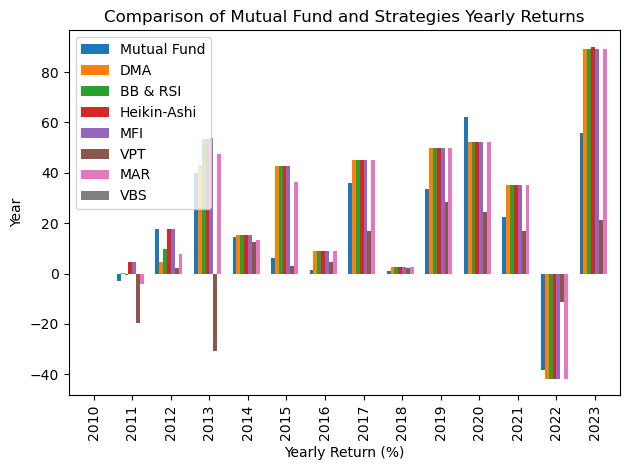

    Date  Mutual Fund        DMA   BB & RSI  Heikin-Ashi        MFI  \
0   2010     0.000000   0.000000   0.000000     0.000000   0.000000   
1   2011    -2.824655   0.353620  -0.415635     4.694454   4.695553   
2   2012    17.750628   4.727065   9.672726    17.743552  17.740493   
3   2013    39.848275  43.198191  53.600253    53.609842  53.617938   
4   2014    14.617621  15.402299  15.406386    15.411178  15.413166   
5   2015     6.316563  42.640870  42.661849    42.660896  42.658411   
6   2016     1.597576   8.948171   8.951584     8.951722   8.951718   
7   2017    36.092833  45.188422  45.199480    45.200399  45.201244   
8   2018     1.017701   2.771133   2.775347     2.773582   2.772937   
9   2019    33.427712  49.824177  49.832407    49.834104  49.835379   
10  2020    62.198218  52.387181  52.392988    52.393213  52.393509   
11  2021    22.638984  35.162610  35.165974    35.164670  35.165807   
12  2022   -38.449666 -41.686132 -41.687397   -41.688091 -41.688578   
13  20

In [37]:
# Merge data for comparison
comparison_df = pd.DataFrame({
    'Date': mutual_fund_yearly_returns.index.year,
    'Mutual Fund': mutual_fund_yearly_returns.values,
    'DMA': average_yearly_returns_df_9['Average Yearly Returns (%)'].values,
    'BB & RSI': average_yearly_returns_df_8['Average Yearly Returns (%)'].values,
    'Heikin-Ashi': average_yearly_returns_df_6['Average Yearly Returns (%)'].values,
    'MFI': average_yearly_returns_df_4['Average Yearly Returns (%)'].values,
    'VPT': average_yearly_returns_df_5['Average Yearly Returns (%)'].values,
    'MAR': average_yearly_returns_df_1['Average Yearly Returns (%)'].values,
    'VBS': average_yearly_returns_df_3['Average Yearly Returns (%)'].values,
})

# Plot the comparison using horizontal bars
plt.figure(figsize=(26, 20))
ax = comparison_df.set_index('Date').plot(kind='bar', title="Comparison of Mutual Fund and Strategies Yearly Returns", width=0.8)
plt.xlabel("Yearly Return (%)")
plt.ylabel("Year")
plt.legend(loc='best')
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

# Print the DataFrame
print(comparison_df)